# EMG Preprocessing Example Code

*Code Made By Lilian Hoffner*

In [1]:
import numpy as np
import logging
import click
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

logger = logging.getLogger(__name__)

def band_pass_filter(emg, sample_rate, lowcut=20, highcut=450, order=4):
    """Filter the emg signal with a bandpass filter.

    Args:
        emg(np.array): emg signal
        sample_rate (int): sampling rate of the emg signal
        lowcut (int, optional): low cutoff frequency. Defaults to 20.
        highcut (int, optional): high cutoff frequency. Defaults to 450.
        order (int, optional): order of the filter. Defaults to 4.

    Returns:
        np.array: filtered emg signal
    """
 
    nyquist_freq = sample_rate / 2
    lowcut_norm = lowcut / nyquist_freq
    highcut_norm = highcut / nyquist_freq

    b, a = signal.butter(order, [lowcut_norm, highcut_norm], btype='bandpass')
    #TODO: extend to 2D array and dataframes
    #  check if 3*max(len(a), len(b)) is less than len(emg)
    if 3 * max(len(a), len(b)) < len(emg):
        emg_filtered = signal.filtfilt(b, a, emg)
    else:
        logger.warning("Filter order is too high for the length of the signal or cutoff frequencies are not appropriate.")
        logger.warning("Emg is not filtered")
        emg_filtered = emg
    
    return emg_filtered

def low_pass_filter(emg, sample_rate, cutoff=10, order=4):
    """Filter the emg signal with a lowpass filter.

    Args:
        emg (np.array): emg signal
        sample_rate (int): sampling rate of the emg signal
        cutoff (int, optional): cutoff frequency. Defaults to 10.
        order (int, optional): order of the filter. Defaults to 4.

    Returns:
        np.array: filtered emg signal
    """
    nyquist_freq = sample_rate / 2
    cutoff_norm = cutoff / nyquist_freq

    b, a = signal.butter(order, cutoff_norm, btype='lowpass')
    # TODO: extend to 2D array and dataframes
    if 3 * max(len(a), len(b)) < len(emg):
        emg_filtered = signal.filtfilt(b, a, emg)
    else:
        logger.warning("Filter order is too high for the length of the signal or cutoff frequencies are not appropriate.")
        logger.warning("Emg is not filtered")
        emg_filtered = emg

    return emg_filtered


def high_pass_filter(emg, sample_rate, cutoff=30, order=4):
    """Filter the emg signal with a highpass filter.

    Args:
        emg (np.array): emg signal
        sample_rate (int): sampling rate of the emg signal
        cutoff (int, optional): cutoff frequency. Defaults to 30.
        order (int, optional): order of the filter. Defaults to 4.

    Returns:
        np.array: filtered emg signal
    """
    nyquist_freq = sample_rate / 2
    cutoff_norm = cutoff / nyquist_freq

    b, a = signal.butter(order, cutoff_norm, btype='highpass')
    if 3 * max(len(a), len(b)) < len(emg):
        emg_filtered = signal.filtfilt(b, a, emg)
    else:
        logger.warning("Filter order is too high for the length of the signal or cutoff frequencies are not appropriate.")
        logger.warning("Emg is not filtered")
        emg_filtered = emg

    return emg_filtered

def center_rectify(emg):
    """Center rectify the emg signal.

    Args:
        emg (np.array): emg signal

    Returns:
        np.array: rectified emg signal
    """
    emg_rectified = np.abs(emg - np.mean(emg))
    return emg_rectified


def clean(emg_signal, sample_rate, lowcut=5, highcut=30, order=4, cutoff=10):
    """Clean the EMG signal.

    Args:
        emg_signal (np.array): emg signal
        sample_rate (int): sampling rate of the emg signal
        lowcut (int, optional): low cutoff frequency. Defaults to 5.
        highcut (int, optional): high cutoff frequency. Defaults to 15.
        order (int, optional): order of the filter. Defaults to 4.
        cutoff (int, optional): cutoff frequency for the lowpass filter. Defaults to 10.

    Returns:
        np.array: cleaned emg signal
    """

    # from Buchanan et al. 2004
    # 1. High-pass filter (5 to 30 Hz, 4th order Butterworth)
    # 2. Rectify
    ## From here, Done in another step
    # 3. Normalization (max activation)
    # 4. Low-pass filter (3 to 10 Hz, 4th order Butterworth)
    # presence of artifacts obliges to do a visual check and manual cleaning

    artefact_detected, artefact_locations = detect_artifacts(emg_signal)
    manual_cleaning_needed = visual_check(emg_signal, artefact_locations)

    if manual_cleaning_needed:
        emg_signal_cleaned = remove_artifacts_manual(emg_signal, artefact_locations)
    else:
        emg_signal_cleaned = remove_artifacts_automatic(emg_signal, artefact_locations)
    
    
    emg_signal_filtered = high_pass_filter(emg_signal_cleaned, sample_rate, highcut, order)
    # emg_signal_filtered = band_pass_filter(emg_signal_cleaned, sample_rate, lowcut, highcut, order)
    emg_signal_rectified = abs(emg_signal_filtered)


    return emg_signal_rectified


def visual_check(emg_signal, artefact_locations):
    """Visual check of the EMG signal to detect artifacts.

    Args:
        emg_signal (np.array): emg signal
        artefact_locations (list): list of indices where artifacts are detected

    Returns:
        bool: True if manual cleaning is needed, False otherwise
    """

    fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
    ax1.plot(emg_signal)
    sns.despine()
    ax1.set_title('Raw EMG signal')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('EMG signal')

    ax3.plot(abs(emg_signal))
    ax3.plot(artefact_locations, abs(emg_signal)[artefact_locations], 'ro', markersize=3)
    sns.despine()
    artefact_count = len(artefact_locations)
    ax3.set_title('EMG signal with detected artifacts')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('EMG signal')
    ax3.legend(['EMG signal', f'{artefact_count} artifacts detected'])
    
    clean_signal = remove_artifacts_automatic(emg_signal, artefact_locations)
    ax2.plot(clean_signal)
    sns.despine()
    ax2.set_title('EMG signal cleaned')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('EMG signal')

    plt.tight_layout()
    # manage screen display position
    mngr = plt.get_current_fig_manager()
    plt.figure(figsize=(14, 8))

    plt.show(block = False)

    user_input = click.prompt('Is artifact detection correct? (y/n)', type=str, default='y')
    # no response is considered as a yes
    if user_input.lower() == 'y' or user_input.lower() == 'yes':
        manual_cleaning = False
    elif user_input.lower() == 'n' or user_input.lower() == 'no':
        manual_cleaning = True
    else:
        logger.warning('Wrong input. No manual cleaning.')
        manual_cleaning = False

    plt.close()
    return manual_cleaning

def detect_artifacts(emg_signal, n_max_value_to_consider=100, n_times_treshold=2, threshold=1):
    """Detect artifacts in the EMG signal.

    Args:
        emg_signal (np.array): emg signal
        n_max_value_to_consider (int, optional): number of values to consider to compute the median. Defaults to 100.
        n_times_treshold (int, optional): factor to multiply the median to get the treshold. Defaults to 2.
        threshold (int, optional): hard treshold. Defaults to 1.

    Returns:
        bool: True if artifacts are detected, False otherwise
        list: list of indices where artifacts are detected
    """
    
    # compute median of the 100 highest values of the signal (emg_signal is a numpy array)
    emg_sorted = np.sort(abs(emg_signal))[::-1]
    median_value = np.median(emg_sorted[:n_max_value_to_consider])


    artefact_locations = []

    # replace values that are n_times_treshold times higher than the median by 0 to avoid extreme values and extension of artifacts duration
    # due to the band pass filter
    # replace by 0
    if any(abs(emg_signal) > n_times_treshold*median_value):
        logger.warning(f"EMG artifacts detected. Method with median_value = {median_value}")
        artefact_locations = np.where(abs(emg_signal) > n_times_treshold*median_value)[0]
    if any(abs(emg_signal) > threshold):
        logger.warning(f"EMG artifacts detected. Method with hard treshold = {threshold}")
        artefact_locations = np.where(abs(emg_signal) > threshold)[0]
    artefact_detected = len(artefact_locations) > 0
    return artefact_detected, artefact_locations

def remove_artifacts_manual(emg_signal, artifact_indices):
    """Remove artifacts in the EMG signal.

    Args:
        emg_signal (np.array): emg signal
        artifact_indices (list): list of indices where artifacts are detected

    Returns:
        np.array: cleaned emg signal
    """
    # clic the plot to place a treshold. Above the treshold, the signal is considered as artifact
    # and will be removed
    response = 'n'
    while response.lower() != 'y':
        plt.close()
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        axes[0].plot(abs(emg_signal))
        sns.despine()

        click_coords = plt.ginput(n=1, timeout=0, show_clicks=True)
        treshold = click_coords[0][1]
        axes[0].axhline(treshold, color='r')

        artifact_indices = np.where(abs(emg_signal) > treshold)[0]
        emg_signal_cleaned = remove_artifacts_automatic(emg_signal, artifact_indices)
        axes[1].plot(emg_signal_cleaned)
        sns.despine()

        axes[0].plot(artifact_indices, abs(emg_signal)[artifact_indices], 'ro', markersize=3)

        artefact_count = len(group_values(artifact_indices))

        for ax in axes:
            # ax.set_title('EMG signal with detected artifacts')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('EMG signal')
            # ax.legend(['EMG signal', f'{len(artifact_indices)} artifacts detected'])
        axes[0].set_title('EMG signal with detected artifacts')
        axes[0].legend(['EMG signal', f'{artefact_count} artifacts detected'])
        axes[1].set_title('EMG signal cleaned')

        plt.show(block=False)
        plt.draw()
        response = click.prompt('Is artifact removal correct? (y/n)', type=str, default='y')
        plt.close()
    
    return emg_signal_cleaned


def remove_artifacts_automatic(emg_signal, artefact_indices):
    """Remove artifacts in the EMG signal.

    Args:
        emg_signal (np.array): emg signal
        artefact_indices (list): list of indices where artifacts are detected

    Returns:
        np.array: cleaned emg signal
    """
    # Simple example: Automatically remove artifacts detected by detect_artifacts
    clean_signal = np.copy(emg_signal)
    # replace the values of the artifacts by the median of the signal. Extend to the left and right by 10 samples
    # to avoid sharp edges
    # group the indices by consecutive values
    artefact_indices_grouped = _group_values(artefact_indices)

    for artefact_indices_group in artefact_indices_grouped:
        if isinstance(artefact_indices_group, list):
            # if the group contains more than one value, replace all values by the median of the signal
            clean_signal[artefact_indices_group[0]-10:artefact_indices_group[1]+10] = np.median(emg_signal)
        else:
            # if the group contains only one value, replace the value +-5 by the median of the signal
            clean_signal[artefact_indices_group-5:artefact_indices_group+5] = np.median(emg_signal)

    return clean_signal

def _group_values(arr):
    """Group consecutive values in an array.

    Args:
        arr (list): array of values

    Returns:
        list: list of grouped values
    """
    # If the array is empty, return an empty list
    if len(arr) == 0:
        return []

    # Sort the array to ensure consecutive values are adjacent
    arr.sort()

    # Initialize the result list and the start of the current group
    result = []
    group_start = arr[0]

    # Iterate through the array
    for i in range(1, len(arr)):
        # Check if the current value is not consecutive
        if arr[i] != arr[i - 1] + 1:
            # If the start and end of the group are different, add both to the result
            if group_start != arr[i - 1]:
                result.append([group_start, arr[i - 1]])
            else:  # If the group contains only one element, add it alone
                result.append(group_start)
            # Update the start of the new group
            group_start = arr[i]

    # Add the last group to the result
    # This is necessary to include the group at the end of the array
    if group_start != arr[-1]:
        result.append([group_start, arr[-1]])
    else:
        result.append(group_start)

    return result


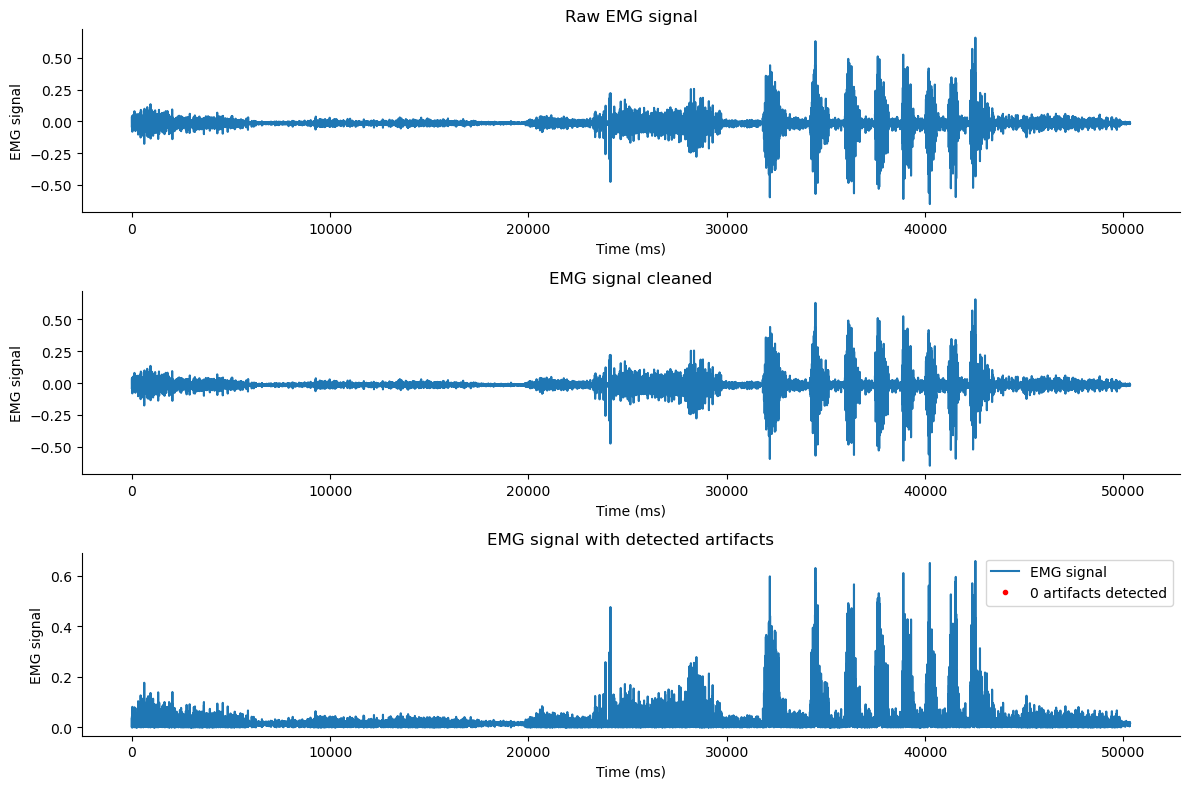

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


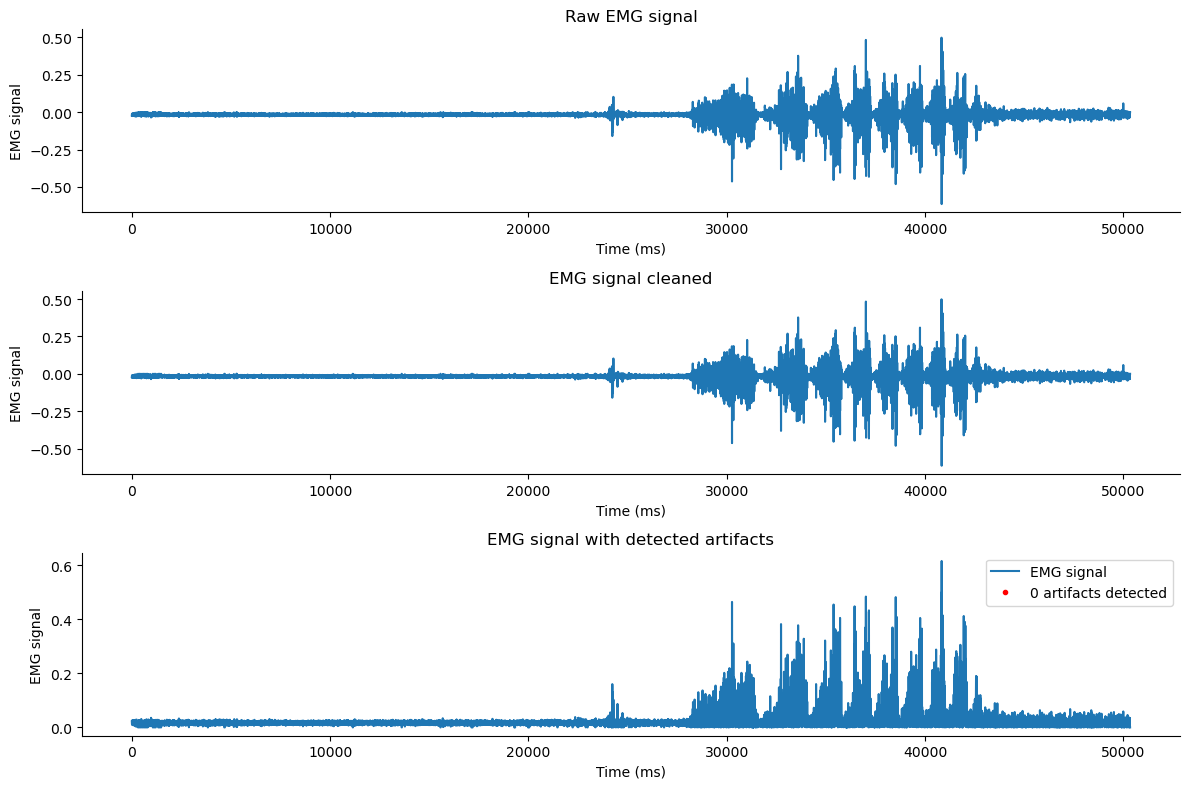

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


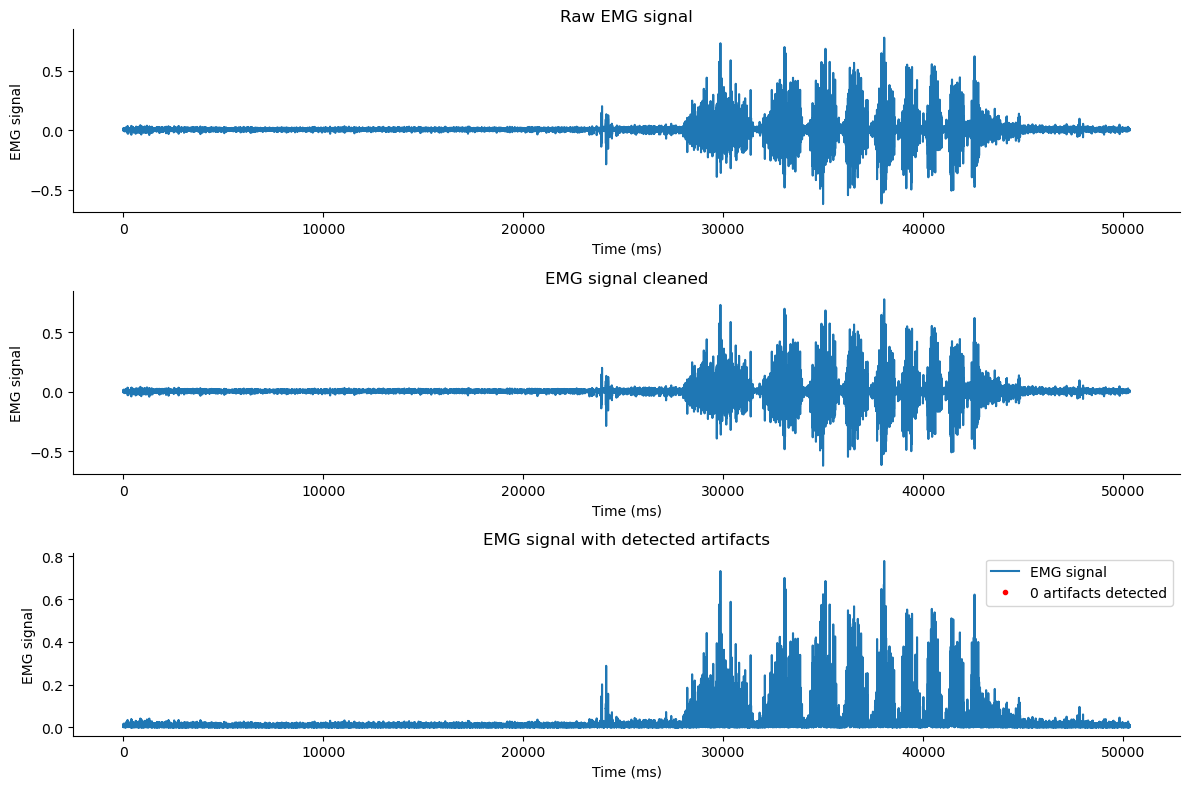

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


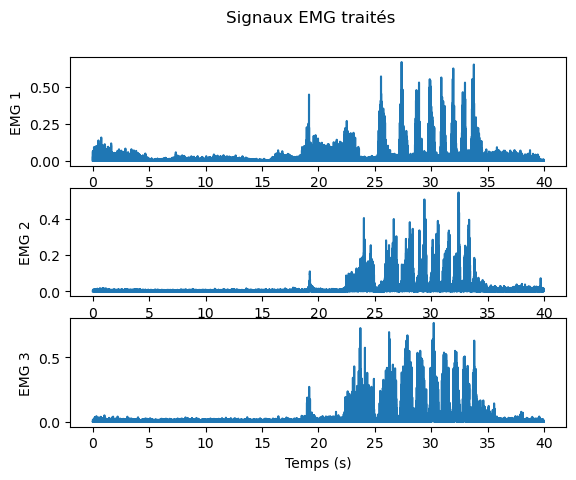

In [6]:
# Code pour un seul fichier CSV
import pandas as pd
import matplotlib.pyplot as plt

# Importer le fichier CSV
data = pd.read_csv('emg_pp.csv', header=None, delimiter=';')

# Extraire les colonnes de signaux EMG
emg1 = data[0].to_numpy()
emg2 = data[1].to_numpy()
emg3 = data[2].to_numpy()

# Définir la fréquence d'échantillonnage
sample_rate = 1259  # Hz

# Créer un tableau de temps correspondant à chaque échantillon
time = np.arange(len(emg1)) / sample_rate

# Traiter chaque signal EMG
emg1_cleaned = clean(emg1, sample_rate)
emg2_cleaned = clean(emg2, sample_rate)
emg3_cleaned = clean(emg3, sample_rate)

# Afficher les signaux EMG traités
fig, axs = plt.subplots(3)
fig.suptitle('Signaux EMG traités')
axs[0].plot(time, emg1_cleaned)
axs[0].set_ylabel('EMG 1')
axs[1].plot(time, emg2_cleaned)
axs[1].set_ylabel('EMG 2')
axs[2].plot(time, emg3_cleaned)
axs[2].set_ylabel('EMG 3')
axs[2].set_xlabel('Temps (s)')
plt.show()


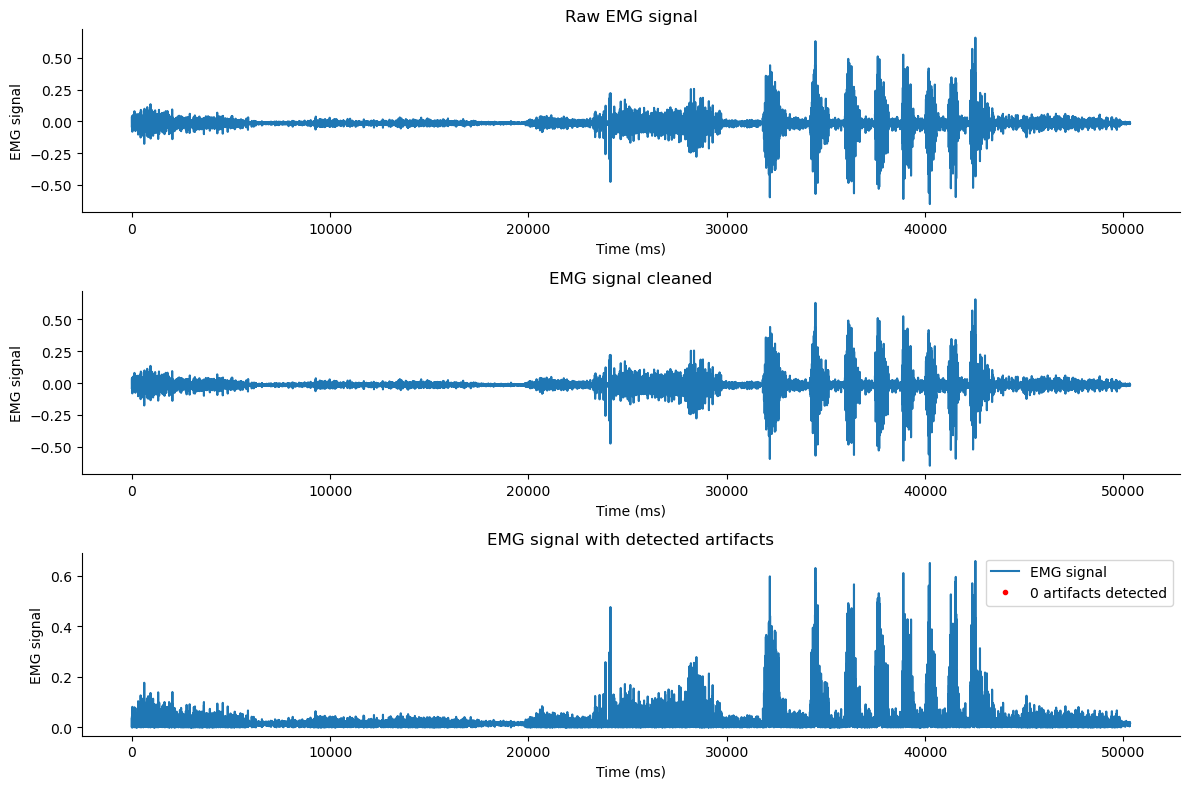

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


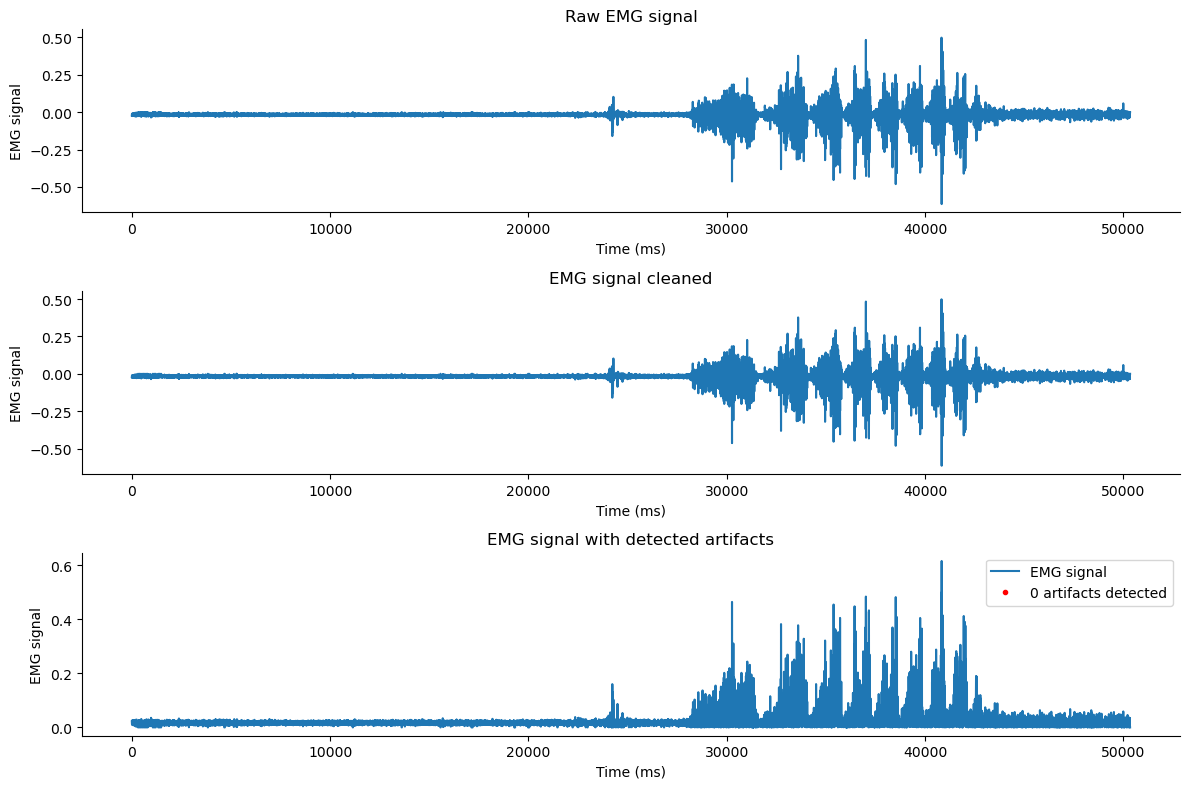

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


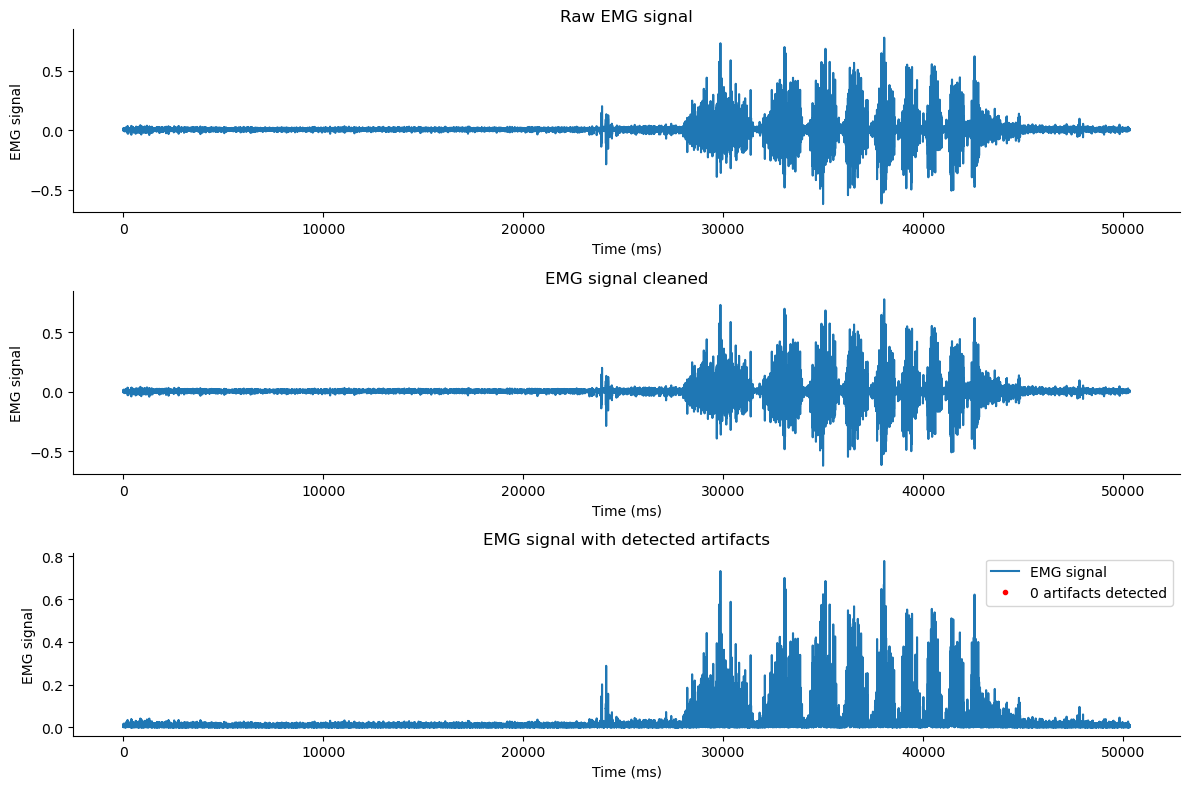

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


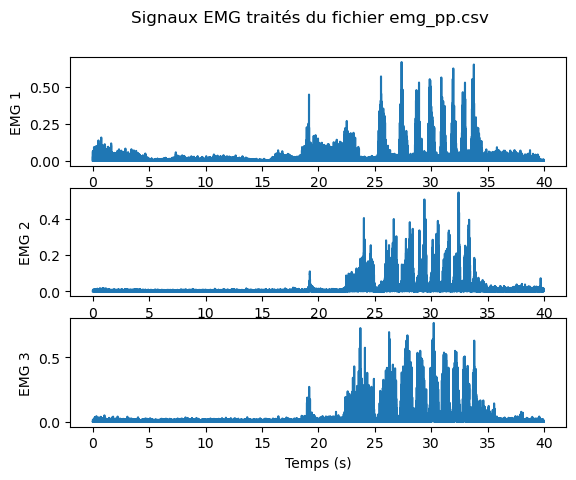

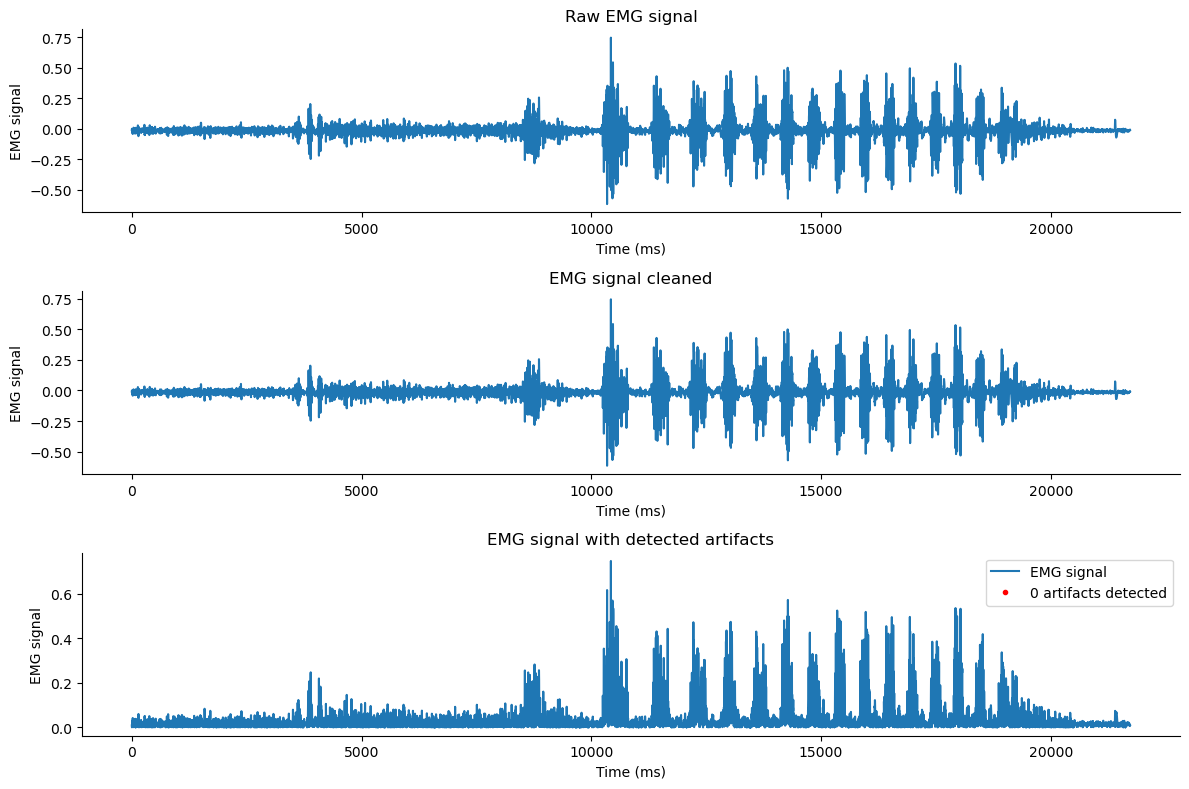

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


EMG artifacts detected. Method with median_value = 0.30078585


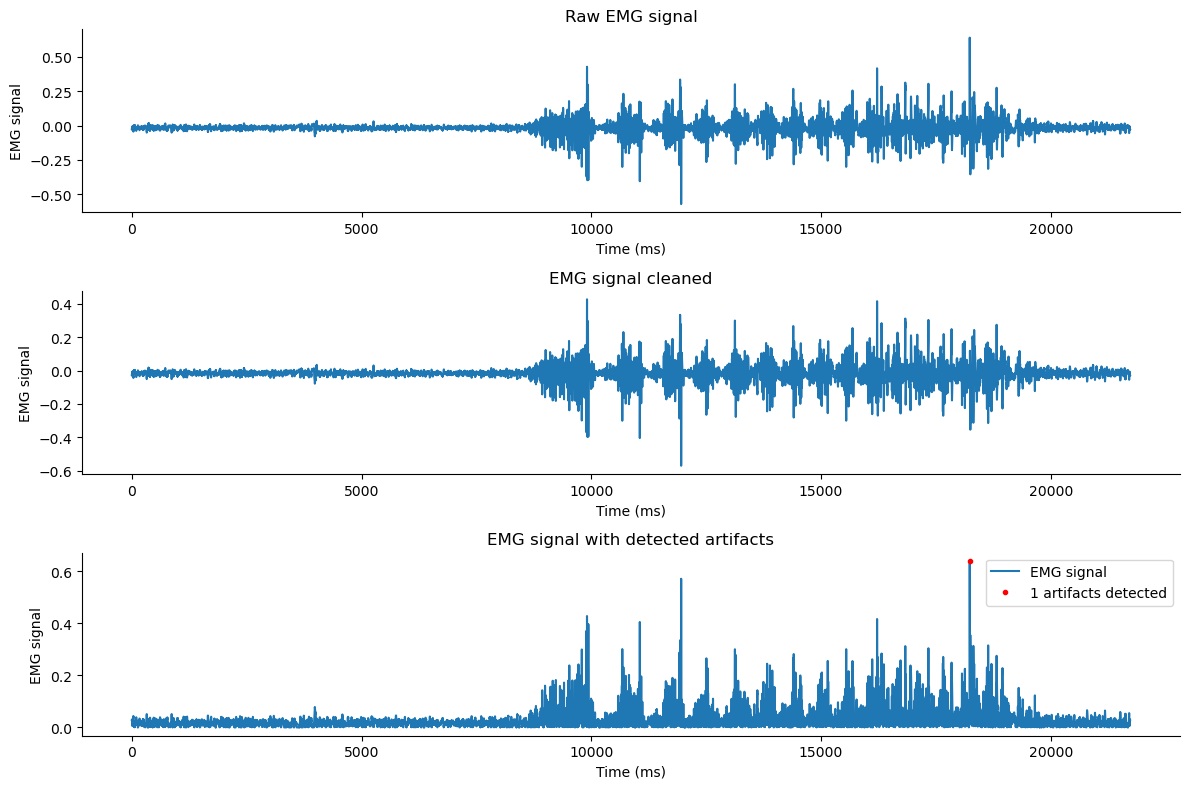

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


EMG artifacts detected. Method with median_value = 0.49784085
EMG artifacts detected. Method with hard treshold = 1


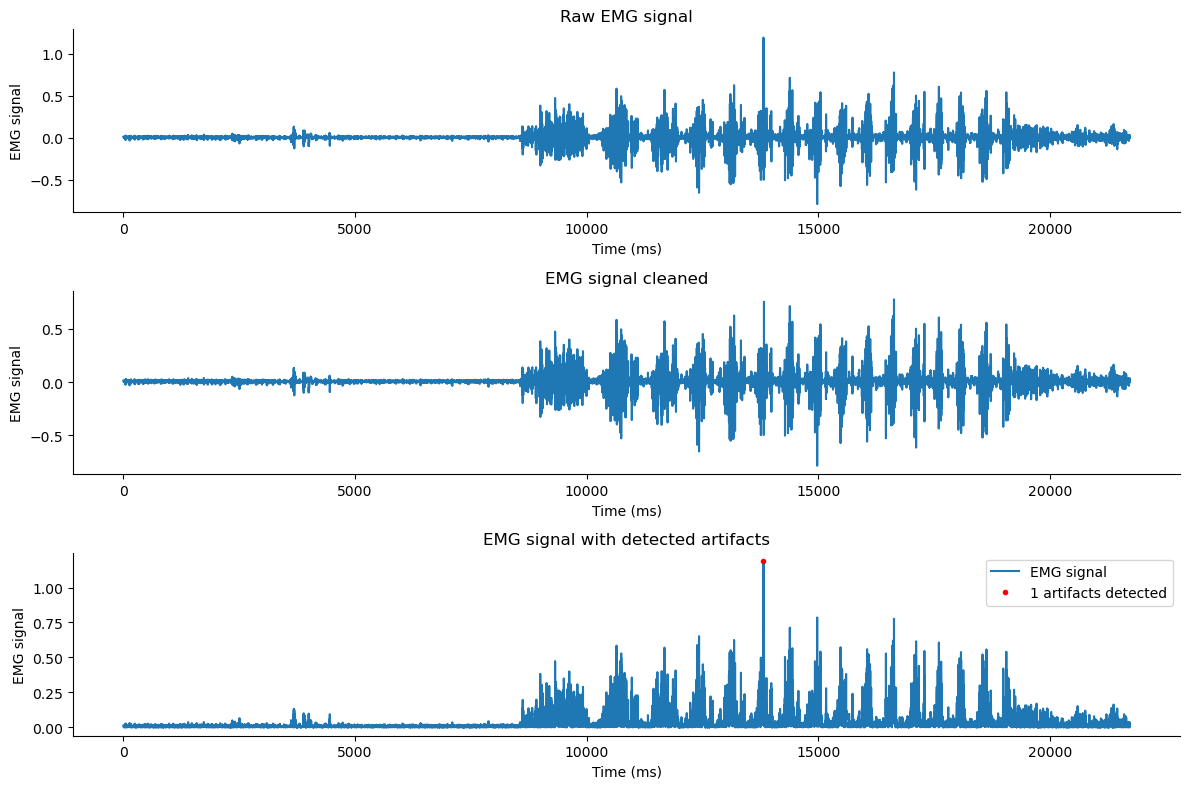

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


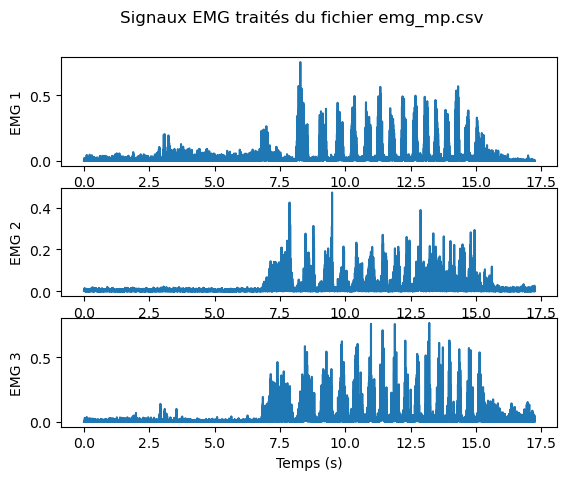

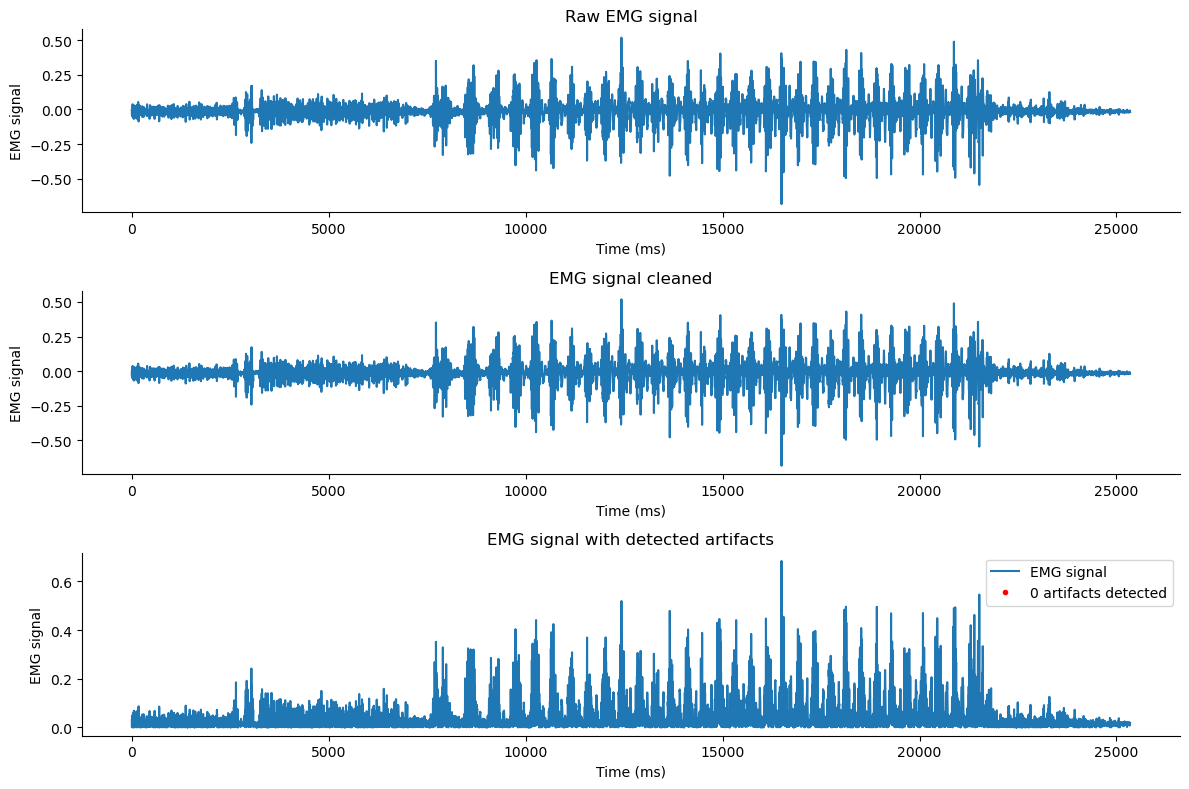

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


EMG artifacts detected. Method with hard treshold = 1


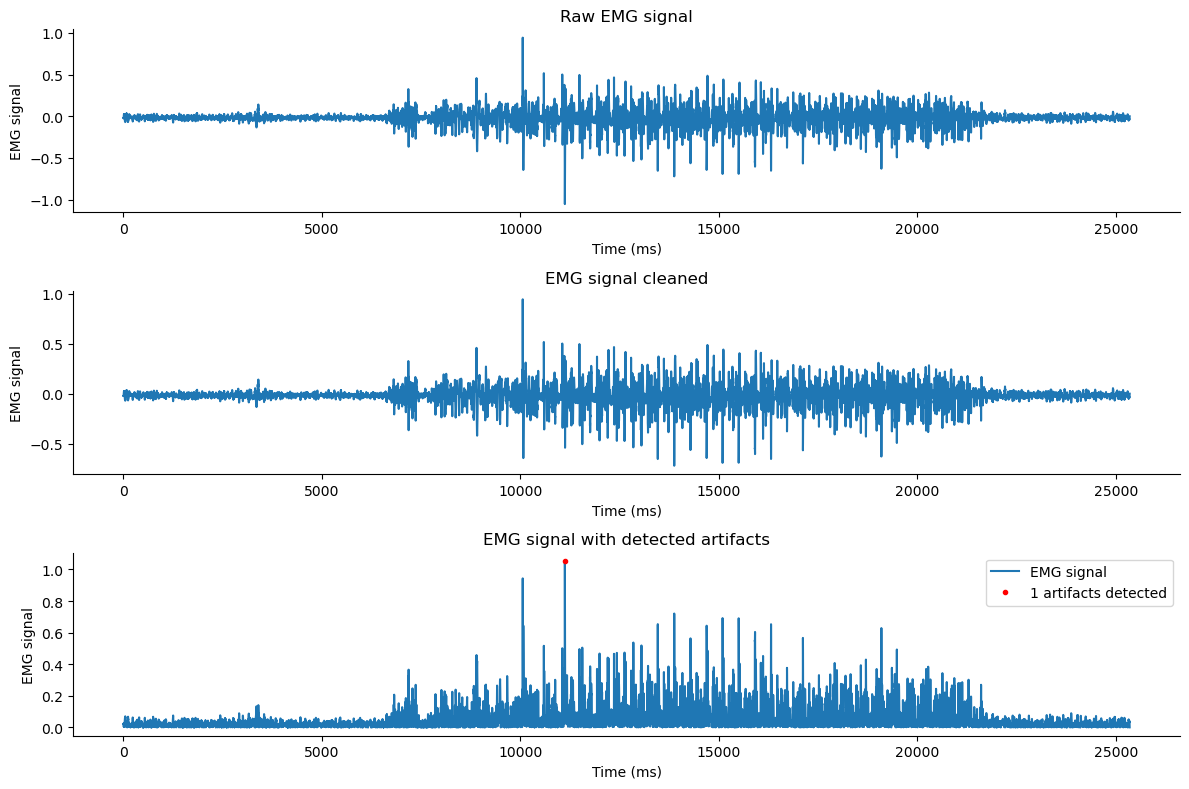

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


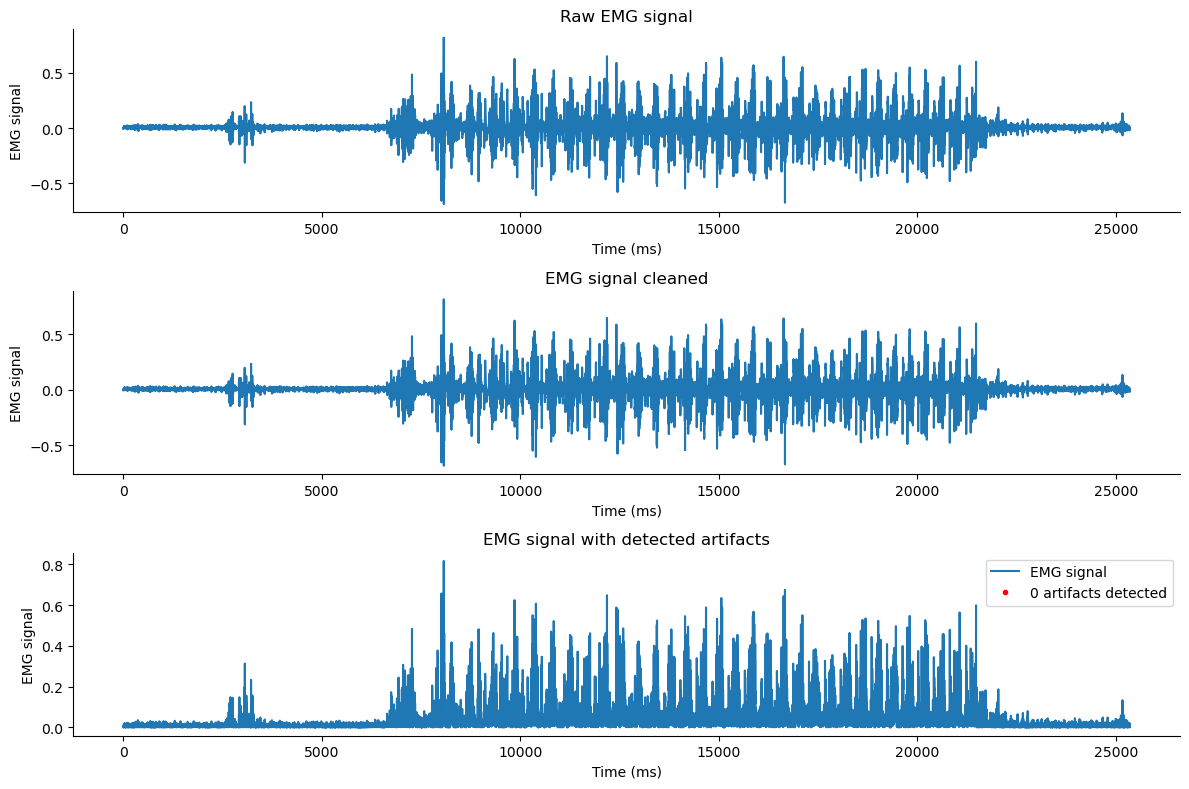

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


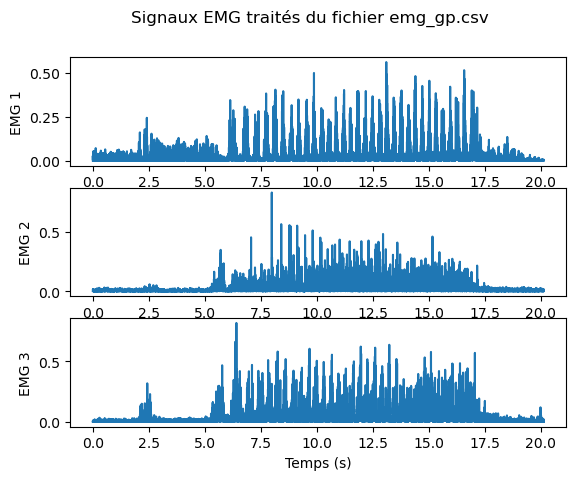

In [2]:
# Code pour plusieurs fichiers CSV

# Définir la fréquence d'échantillonnage
sample_rate = 1259  # Hz

# Définir les noms des fichiers CSV
filenames = ['emg_pp.csv', 'emg_mp.csv', 'emg_gp.csv']

# Définir le nombre de fichiers pour organiser les graphiques
num_files = len(filenames)

# Parcourir chaque fichier CSV
for i, filename in enumerate(filenames):
    # Importer le fichier CSV
    data = pd.read_csv(filename, header=None, delimiter=';')

    # Extraire les colonnes de signaux EMG
    emg1 = data[0].to_numpy()
    emg2 = data[1].to_numpy()
    emg3 = data[2].to_numpy()

    # Créer un tableau de temps correspondant à chaque échantillon
    time = np.arange(len(emg1)) / sample_rate

    # Traiter chaque signal EMG
    emg1_cleaned = clean(emg1, sample_rate)
    emg2_cleaned = clean(emg2, sample_rate)
    emg3_cleaned = clean(emg3, sample_rate)

    # Afficher les signaux EMG traités
    fig, axs = plt.subplots(3)
    fig.suptitle(f'Signaux EMG traités du fichier {filename}')
    axs[0].plot(time, emg1_cleaned)
    axs[0].set_ylabel('Vaste medial')
    axs[1].plot(time, emg2_cleaned)
    axs[1].set_ylabel('Biceps femoral')
    axs[2].plot(time, emg3_cleaned)
    axs[2].set_ylabel('Gastrocnemiens lateral')
    axs[2].set_xlabel('Temps (s)')

    # Afficher le graphique
    plt.show()

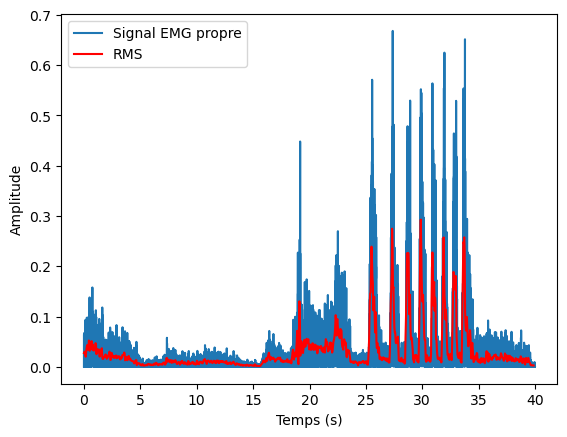

In [3]:
# calcul du RMS
# Définir la taille de la fenêtre glissante (en nombre d'échantillons)
window_size = 100

# Définir le chevauchement entre les fenêtres (en nombre d'échantillons)
overlap = 50

# Calculer le nombre de segments à l'aide de la taille de la fenêtre et du chevauchement
n_segments = int((len(emg1_cleaned) - window_size) / (window_size - overlap) + 1)

# Créer un tableau pour stocker les valeurs RMS
rms_values = np.zeros(n_segments)

# Calculer le RMS pour chaque segment
for i in range(n_segments):
    start = i * (window_size - overlap)
    stop = start + window_size
    rms_values[i] = np.sqrt(np.mean(emg1_cleaned[start:stop]**2))

# Créer un tableau pour stocker les temps correspondant aux valeurs RMS
time = np.arange(n_segments) * (window_size - overlap) / sample_rate

# Créer un tableau de temps pour le signal EMG propre
time_emg = np.arange(len(emg1_cleaned)) / sample_rate

# Tracer le signal EMG propre et la courbe RMS
fig, ax = plt.subplots()
ax.plot(time_emg, emg1_cleaned, label='Signal EMG propre')
ax.plot(time, rms_values, 'r', label='RMS')
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.show()

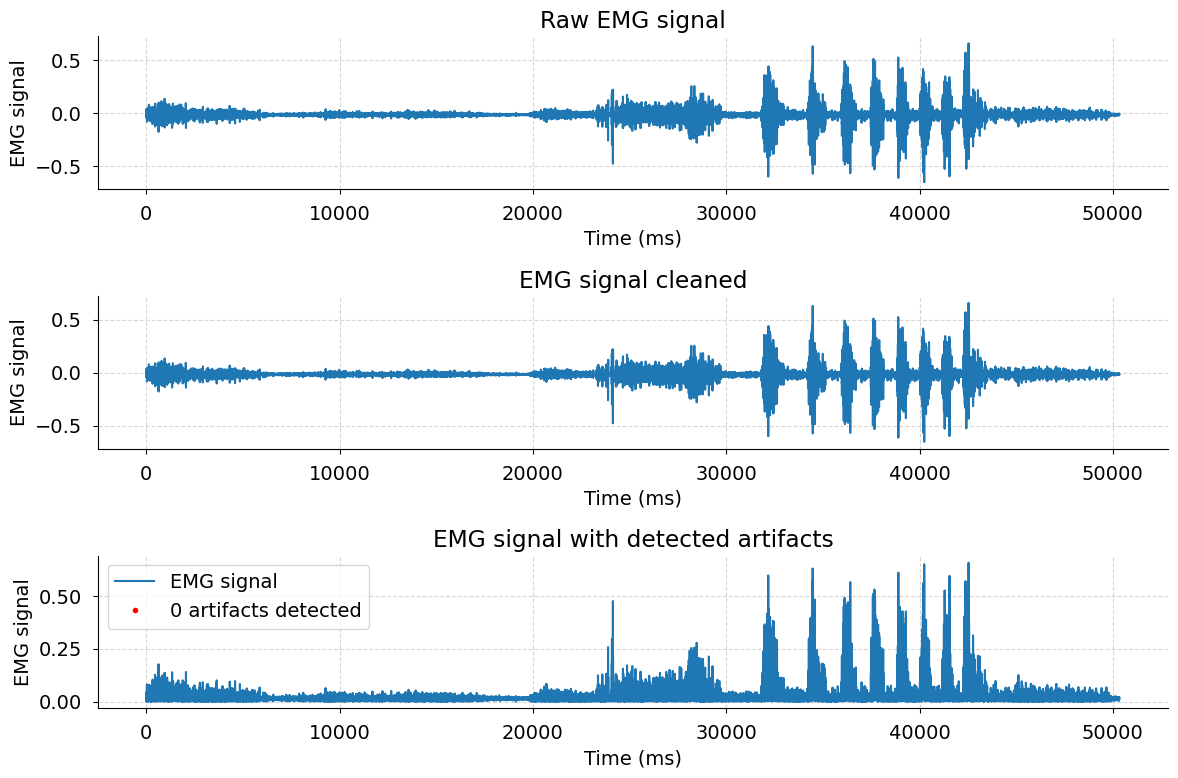

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


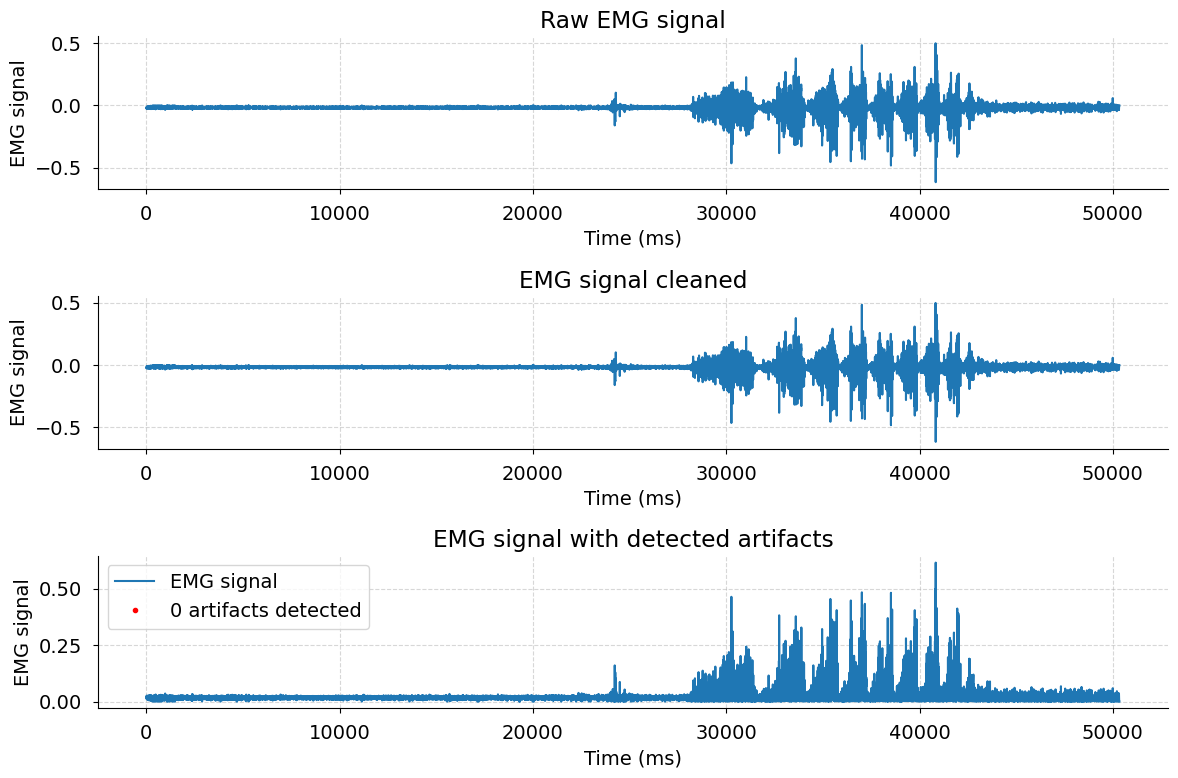

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


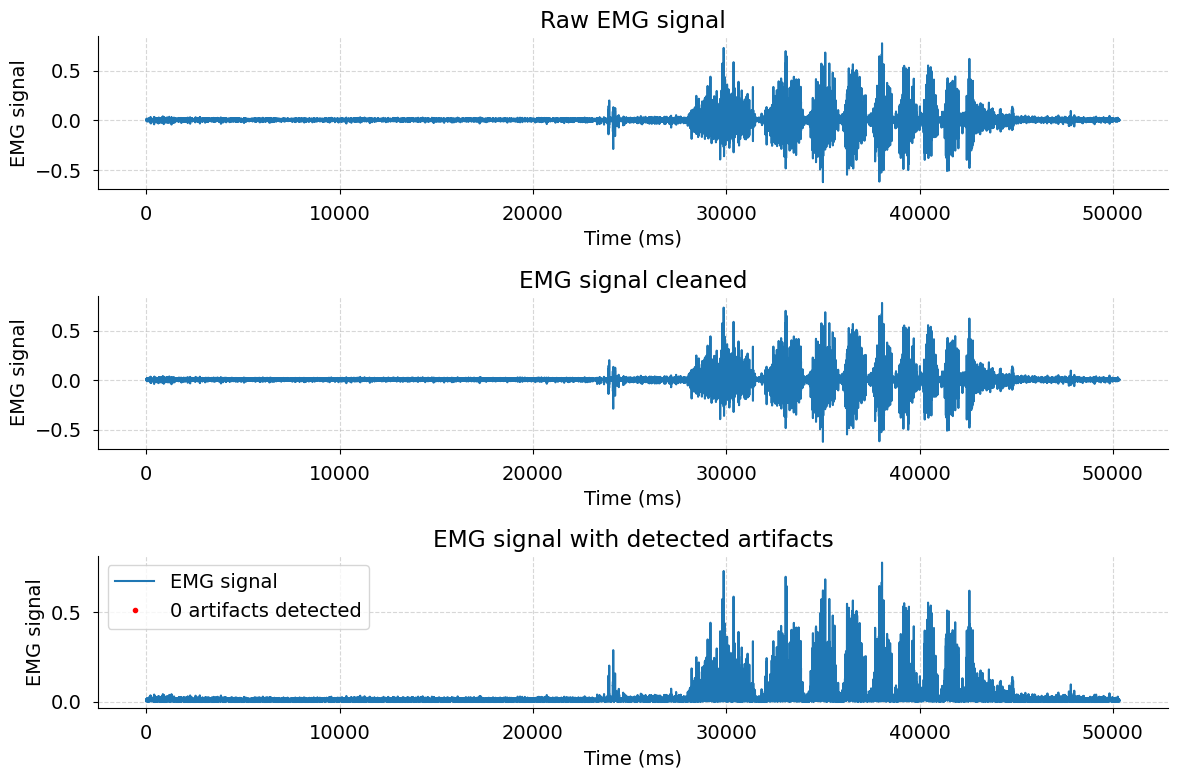

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


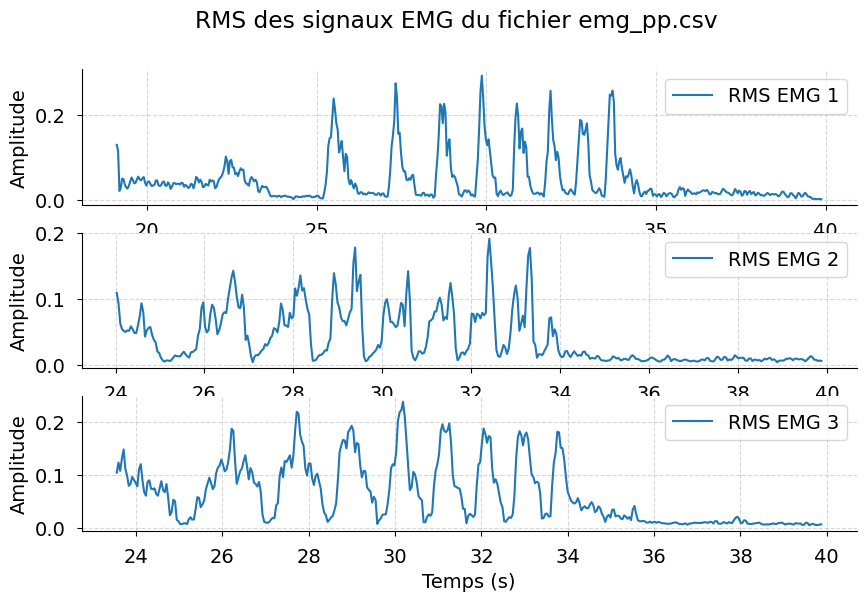

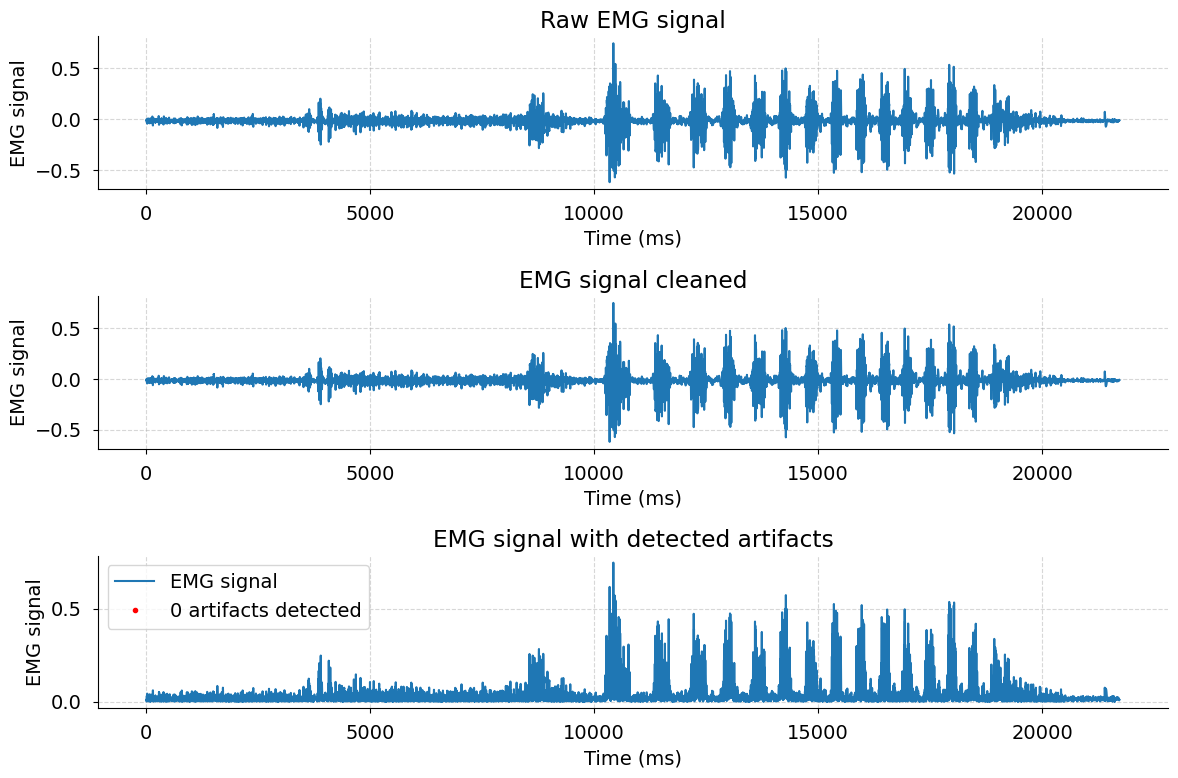

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


EMG artifacts detected. Method with median_value = 0.30078585


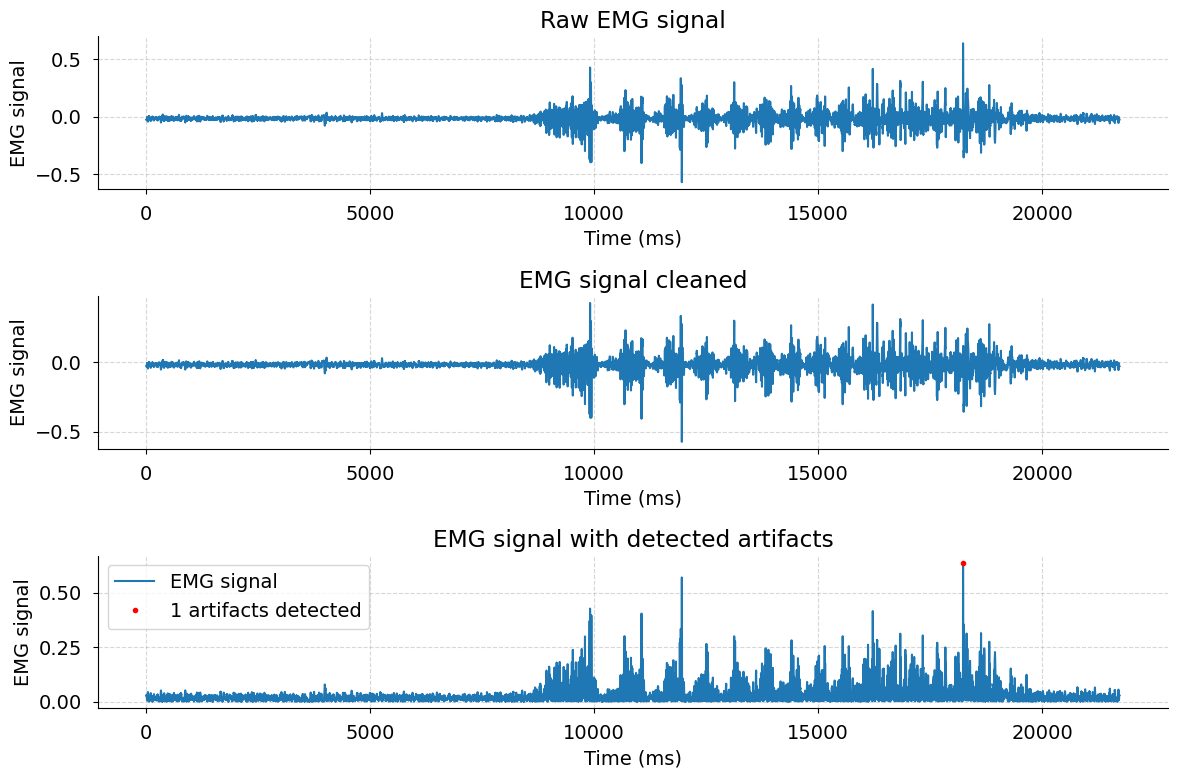

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


EMG artifacts detected. Method with median_value = 0.49784085
EMG artifacts detected. Method with hard treshold = 1


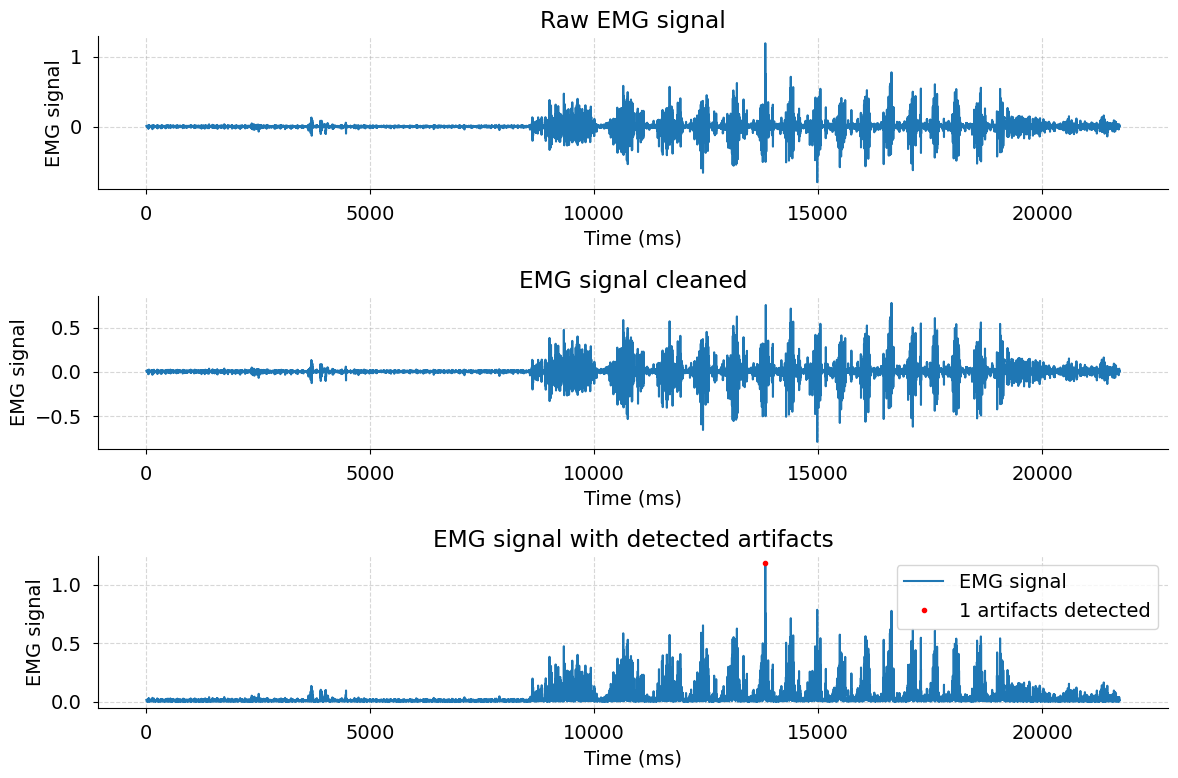

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


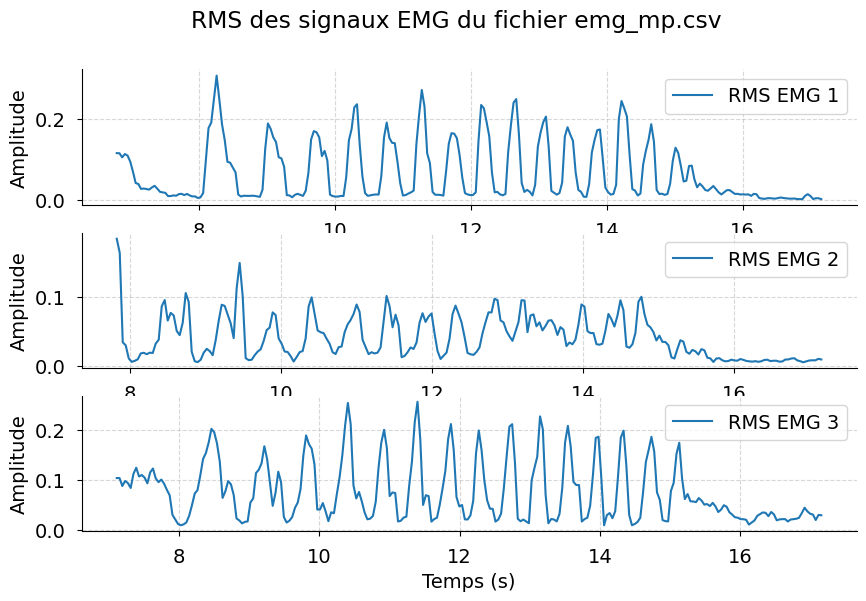

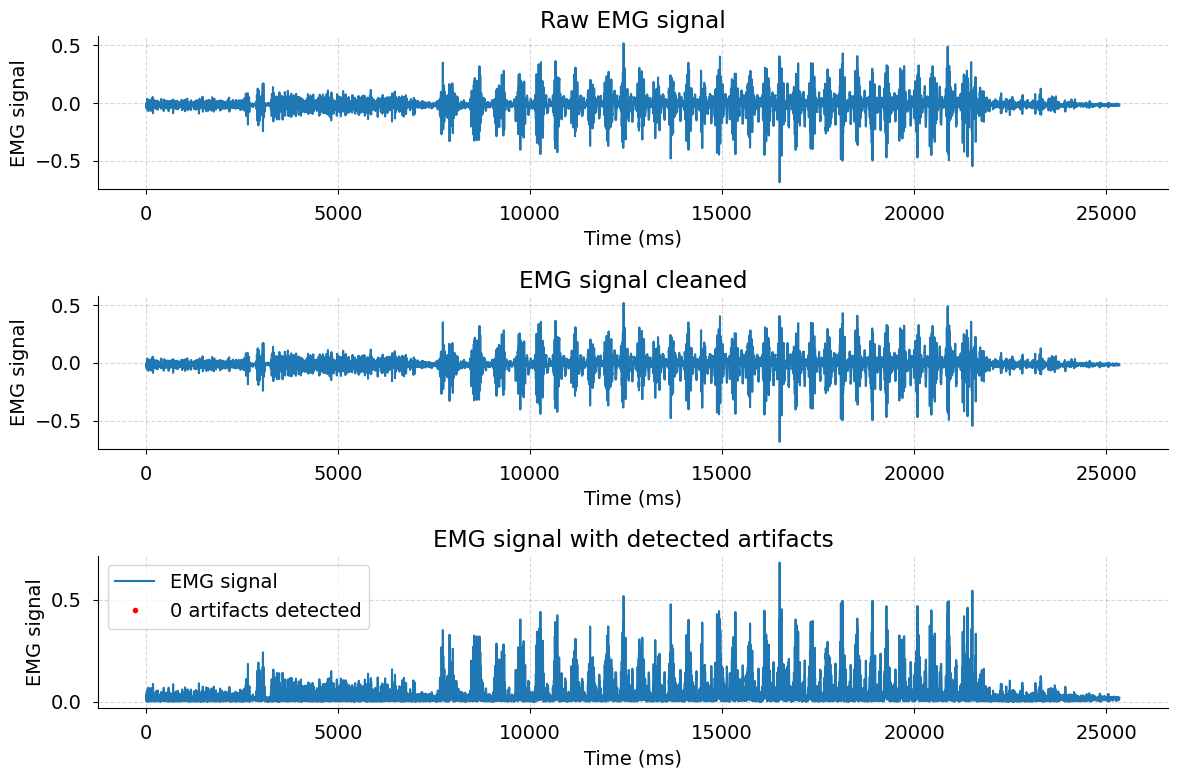

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


EMG artifacts detected. Method with hard treshold = 1


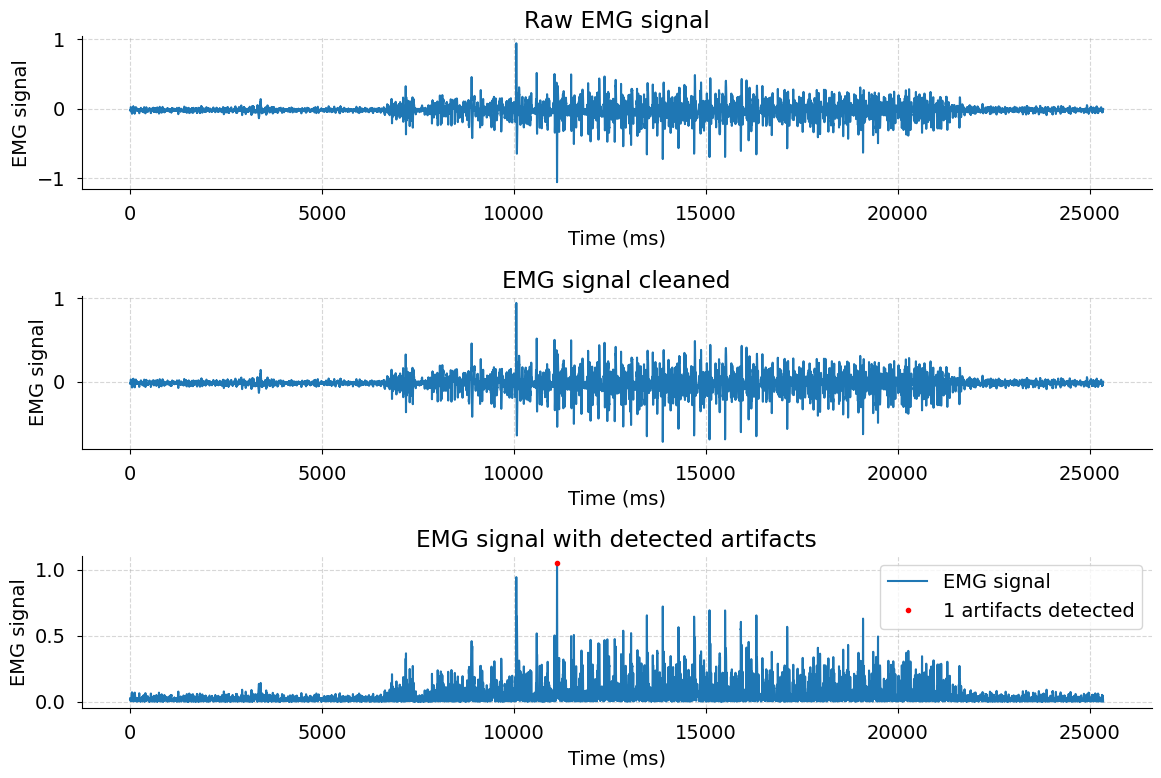

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


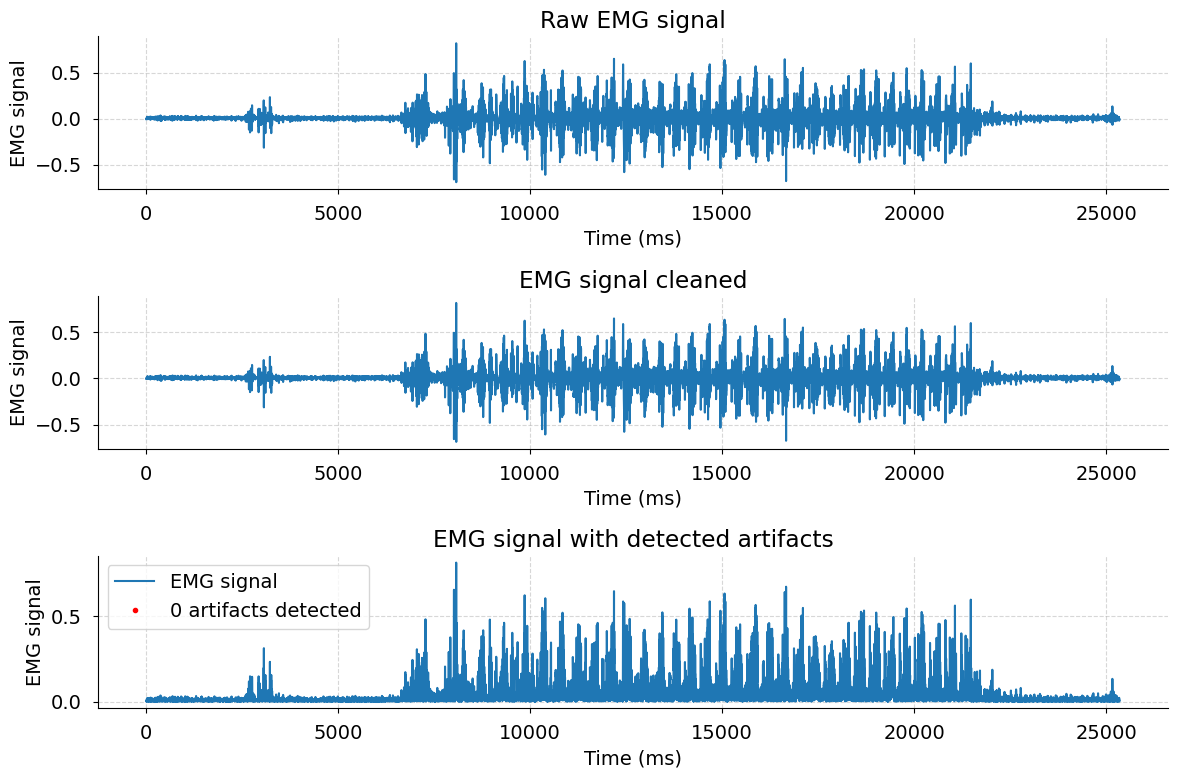

<Figure size 1400x800 with 0 Axes>

Is artifact detection correct? (y/n) [y]: y


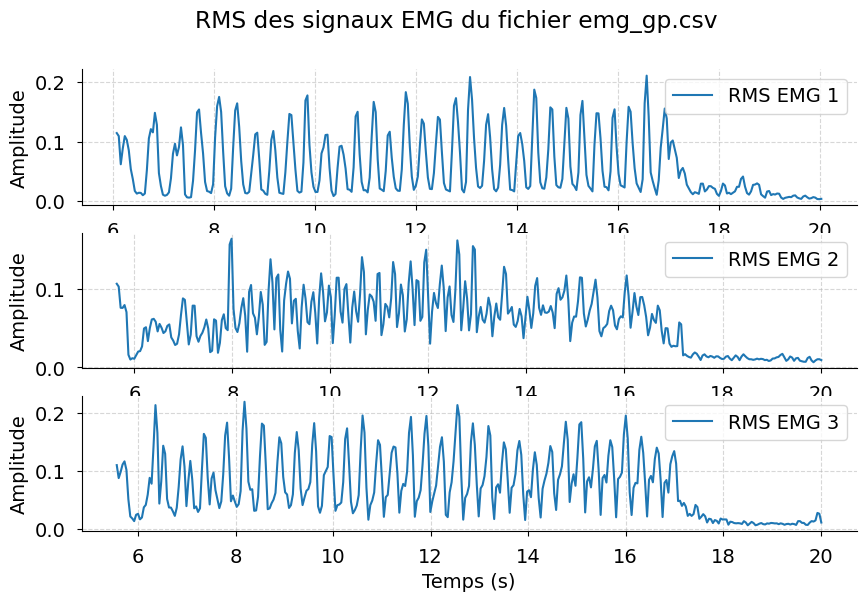

Moyenne des RMS pour chaque muscle et chaque condition :
Vaste médial :
emg_pp : 0.048315292889635444
emg_mp : 0.04054705972463789
emg_gp : 0.0641633906245931
Biceps fémoral :
emg_pp : 0.06885572801899398
emg_mp : 0.04194393407357289
emg_gp : 0.07731770548066322
Gastrocnémiens latéral :
emg_pp : 0.05953601333713337
emg_mp : 0.06009338876892184
emg_gp : 0.07560769060484443
Écart type des RMS pour chaque muscle et chaque condition :
Vaste médial :
emg_pp : 0.05548314038224099
emg_mp : 0.039499555074749906
emg_gp : 0.05846654033408015

Biceps fémoral :
emg_pp : 0.0720678503568925
emg_mp : 0.0315235505017872
emg_gp : 0.059628020008527925

Gastrocnémiens latéral :
emg_pp : 0.05194830783207946
emg_mp : 0.03617345367474841
emg_gp : 0.05343823604396751



In [38]:
# Calcul du RMS dans le cas de plusieurs fichiers csv
def find_first_peak_index(signal, threshold):
    for i in range(len(signal)):
        if signal[i] > threshold:
            return i
    return -1

# Initialiser les listes pour stocker les moyennes des RMS pour chaque muscle et chaque condition
mean_rms_emg1 = []
mean_rms_emg2 = []
mean_rms_emg3 = []

std_rms_emg1 = []
std_rms_emg2 = []
std_rms_emg3 = []

# Parcourir chaque fichier CSV
for filename in filenames:
    # Importer le fichier CSV
    data = pd.read_csv(filename, header=None, delimiter=';')

    # Extraire les colonnes de signaux EMG
    emg1 = data[0].to_numpy()
    emg2 = data[1].to_numpy()
    emg3 = data[2].to_numpy()

    # Traiter chaque signal EMG
    emg1_cleaned = clean(emg1, sample_rate)
    emg2_cleaned = clean(emg2, sample_rate)
    emg3_cleaned = clean(emg3, sample_rate)

    # Calculer le RMS pour chaque signal EMG
    rms_emg1 = calculate_rms(emg1_cleaned, window_size, overlap, sample_rate)
    rms_emg2 = calculate_rms(emg2_cleaned, window_size, overlap, sample_rate)
    rms_emg3 = calculate_rms(emg3_cleaned, window_size, overlap, sample_rate)

    # Trouver l'index du premier pic qui dépasse 0.1 en ordonnée
    first_peak_index1 = find_first_peak_index(rms_emg1[1], 0.1)
    first_peak_index2 = find_first_peak_index(rms_emg2[1], 0.1)
    first_peak_index3 = find_first_peak_index(rms_emg3[1], 0.1)

    # Calculer la moyenne des RMS pour chaque muscle à partir de l'index du premier pic
    mean_rms_emg1.append(np.mean(rms_emg1[1][first_peak_index1:]))
    mean_rms_emg2.append(np.mean(rms_emg2[1][first_peak_index2:]))
    mean_rms_emg3.append(np.mean(rms_emg3[1][first_peak_index3:]))
    
    # Calculer l'écart type des RMS pour chaque muscle à partir de l'index du premier pic
    std_rms_emg1.append(np.std(rms_emg1[1][first_peak_index1:]))
    std_rms_emg2.append(np.std(rms_emg2[1][first_peak_index2:]))
    std_rms_emg3.append(np.std(rms_emg3[1][first_peak_index3:]))

    # Afficher les courbes RMS des 3 signaux EMG à partir de l'index du premier pic
    fig, axs = plt.subplots(3)
    fig.suptitle(f'RMS des signaux EMG du fichier {filename}')
    axs[0].plot(rms_emg1[0][first_peak_index1:], rms_emg1[1][first_peak_index1:], label='RMS EMG 1')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend()
    axs[1].plot(rms_emg2[0][first_peak_index2:], rms_emg2[1][first_peak_index2:], label='RMS EMG 2')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend()
    axs[2].plot(rms_emg3[0][first_peak_index3:], rms_emg3[1][first_peak_index3:], label='RMS EMG 3')
    axs[2].set_ylabel('Amplitude')
    axs[2].set_xlabel('Temps (s)')
    axs[2].legend()
    plt.savefig('graphique_rms.png', bbox_inches='tight')
    plt.show()

# Afficher les moyennes des RMS pour chaque muscle et chaque condition
print("Moyenne des RMS pour chaque muscle et chaque condition :")
for i in range(3):
    print(f"{muscles[i]} :")
    print(f"emg_pp : {mean_rms_emg1[i]}")
    print(f"emg_mp : {mean_rms_emg2[i]}")
    print(f"emg_gp : {mean_rms_emg3[i]}")
    
# Afficher les écarts types des RMS pour chaque muscle et chaque condition
print("Écart type des RMS pour chaque muscle et chaque condition :")
for i in range(3):
    print(f"{muscles[i]} :")
    print(f"emg_pp : {std_rms_emg1[i]}")
    print(f"emg_mp : {std_rms_emg2[i]}")
    print(f"emg_gp : {std_rms_emg3[i]}")
    print()
